# Explainability

In [35]:
# Imports
import os
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [37]:
# Load model and test data
model = joblib.load("/Users/rohith/Desktop/fraud-detection-ml/Models/rf_champion.joblib")
X_test = np.load("/Users/rohith/Desktop/fraud-detection-ml/Data/prep/creditcard_x_test.npy")
y_test = np.load("/Users/rohith/Desktop/fraud-detection-ml/Data/prep/creditcard_y_test.npy")

FEATURE_NAMES = [
    'V2', 'V3', 'V4',
    'V11', 'V12', 'V14',
    'V16', 'V17', 'V18',
    'V7', 'V10'
]

X_df = pd.DataFrame(X_test, columns=FEATURE_NAMES)

In [38]:
# Sample a subset for SHAP
np.random.seed(42)
idx_sample = np.random.choice(X_df.index, size=min(5000, len(X_df)), replace=False)
X_sample = X_df.loc[idx_sample]
y_sample = y_test[idx_sample]

In [39]:
# SHAP global summary
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_sample)

print(f"Raw SHAP values shape: {np.array(shap_vals).shape}")
print(f"SHAP values type: {type(shap_vals)}")


Raw SHAP values shape: (5000, 11, 2)
SHAP values type: <class 'numpy.ndarray'>


In [41]:
# Handle different SHAP output formats
if isinstance(shap_vals, list):
    # Binary classification: use positive class (index 1)
    shap_vals_pos = shap_vals[1]
    expected_value = explainer.expected_value[1]
elif len(shap_vals.shape) == 3:
    # Shape is (n_samples, n_features, n_classes) - take positive class
    shap_vals_pos = shap_vals[:, :, 1]
    expected_value = explainer.expected_value[1] if hasattr(explainer.expected_value, '__len__') else explainer.expected_value
else:
    # Single output (e.g., for some tree models)
    shap_vals_pos = shap_vals
    expected_value = explainer.expected_value

print(f"SHAP values shape after processing: {shap_vals_pos.shape}")
print(f"X_sample shape: {X_sample.shape}")

SHAP values shape after processing: (5000, 11)
X_sample shape: (5000, 11)


Mean absolute SHAP values shape: (11,)
Order array: [ 0  1 10  8  6  9  7  2  5  3  4]
Order shape: (11,)
Order dtype: int64


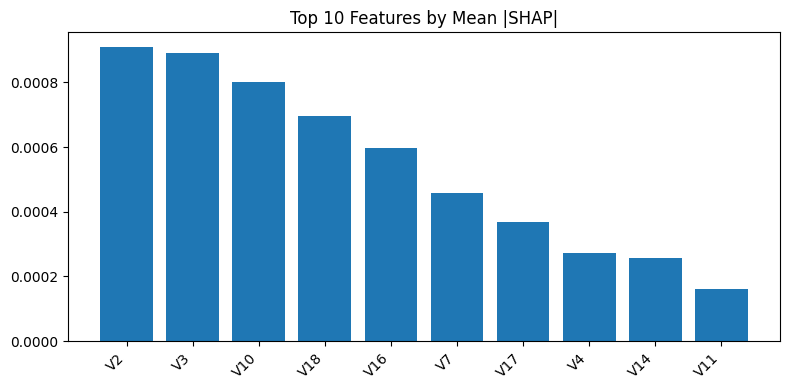

In [42]:
# Bar plot: mean absolute SHAP values
mean_abs = np.abs(shap_vals_pos).mean(axis=0)
print(f"Mean absolute SHAP values shape: {mean_abs.shape}")
order = np.argsort(mean_abs)[::-1]
print(f"Order array: {order}")
print(f"Order shape: {order.shape}")
print(f"Order dtype: {order.dtype}")
plt.figure(figsize=(8, 4))
# Convert order to integers and slice properly
top_features = [FEATURE_NAMES[int(i)] for i in order[:10]]
top_values = mean_abs[order[:10]]
plt.bar(top_features, top_values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Features by Mean |SHAP|')
plt.tight_layout()
plt.savefig('/Users/rohith/Desktop/fraud-detection-ml/reports/evaluation/shap_summary_bar.png')
plt.show()
plt.close()

/var/folders/82/87xd0yg57r1gc_vh3xv9zrlw0000gn/T/ipykernel_21754/576432849.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_pos, X_sample, feature_names=FEATURE_NAMES, show=False)


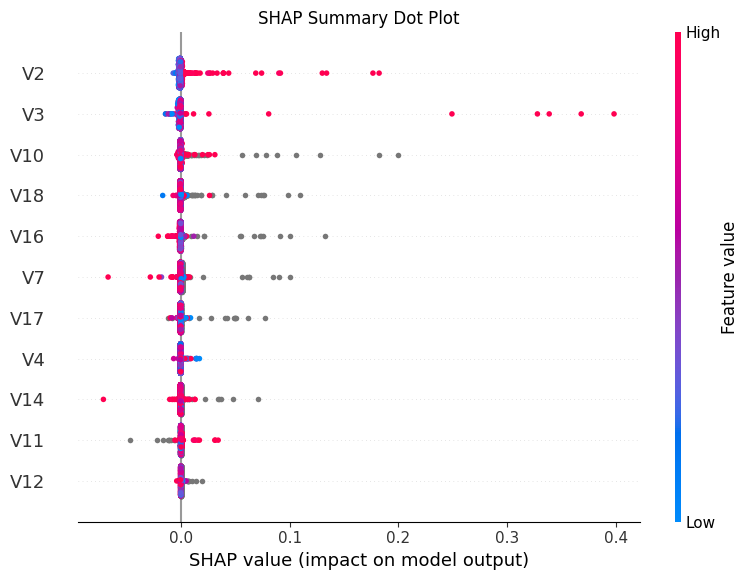

In [43]:
# Dot summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_vals_pos, X_sample, feature_names=FEATURE_NAMES, show=False)
plt.title('SHAP Summary Dot Plot')
plt.tight_layout()
plt.savefig('/Users/rohith/Desktop/fraud-detection-ml/reports/evaluation/shap_summary_dot.png')
plt.show()
plt.close()

Top 3 features for PDP: ['V2', 'V3', 'V10']
Filled NaN values in feature V11 with median: 0.300489
Filled NaN values in feature V12 with median: -0.057012
Filled NaN values in feature V14 with median: 0.239337
Filled NaN values in feature V16 with median: 0.012454
Filled NaN values in feature V17 with median: 0.221633
Filled NaN values in feature V18 with median: 0.088819
Filled NaN values in feature V7 with median: 0.155227
Filled NaN values in feature V10 with median: -0.110962
Creating PDP for feature: V2 (index: 0)
Feature V2 - Min: -5.266509, Max: 15.304184, Mean: -0.202911


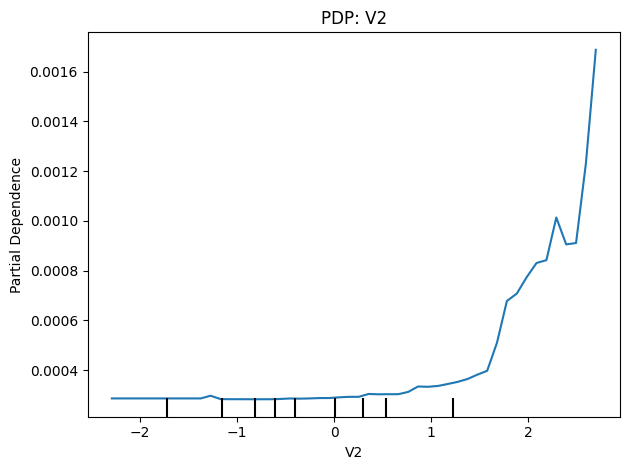

Creating PDP for feature: V3 (index: 1)
Feature V3 - Min: -3.962664, Max: 6.853897, Mean: -0.318068


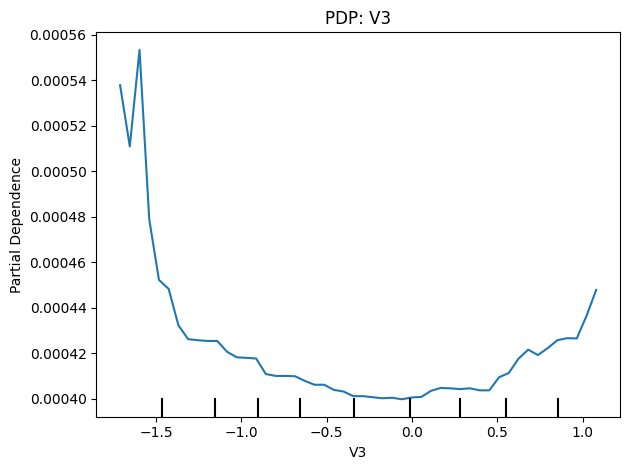

Creating PDP for feature: V10 (index: 10)
NOTE: Feature V10 has 2407 NaN values (5.8%), using median-filled version for PDP
Feature V10 - Min: -11.354136, Max: 2.014759, Mean: -0.273295


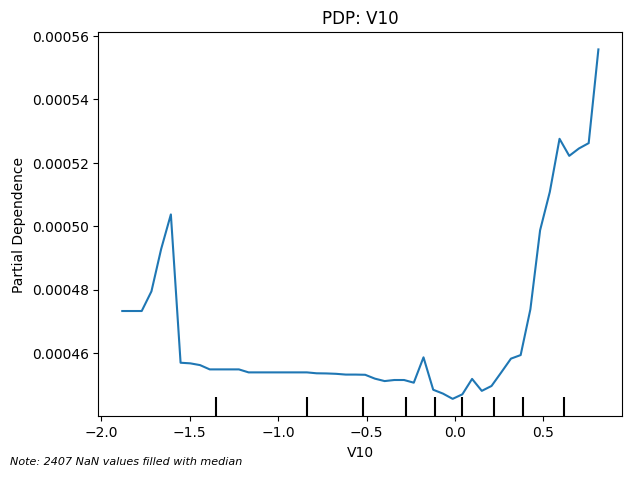

In [ ]:
# Partial Dependence Plots for top 3 features
top3_feats = [FEATURE_NAMES[int(i)] for i in order[:3]]
print(f"Top 3 features for PDP: {top3_feats}")

# Create a version of X_test with NaN values filled for PDP analysis
X_test_filled = X_test.copy()
for i in range(X_test.shape[1]):
    if np.isnan(X_test[:, i]).any():
        # Fill NaN with median of non-NaN values
        median_val = np.nanmedian(X_test[:, i])
        X_test_filled[:, i] = np.where(np.isnan(X_test[:, i]), median_val, X_test[:, i])
        print(f"Filled NaN values in feature {FEATURE_NAMES[i]} with median: {median_val:.6f}")

for feat in top3_feats:
    feat_idx = FEATURE_NAMES.index(feat)
    print(f"Creating PDP for feature: {feat} (index: {feat_idx})")
    
    # Check for NaN values in original data
    feat_values = X_test[:, feat_idx]
    nan_count = np.isnan(feat_values).sum()
    
    if nan_count > 0:
        print(f"NOTE: Feature {feat} has {nan_count} NaN values ({nan_count/len(feat_values)*100:.1f}%), using median-filled version for PDP")
        feat_values_clean = X_test_filled[:, feat_idx]
    else:
        feat_values_clean = feat_values
    
    print(f"Feature {feat} - Min: {feat_values_clean.min():.6f}, Max: {feat_values_clean.max():.6f}, Mean: {feat_values_clean.mean():.6f}")
    
    try:
        # Use filled data for PDP
        disp = PartialDependenceDisplay.from_estimator(
            model, X_test_filled, [feat_idx], grid_resolution=50
        )
        
        # Set the feature name for display
        disp.feature_names = [feat]
        
        plt.title(f"PDP: {feat}")
        plt.xlabel(feat)
        plt.ylabel('Partial Dependence')
        
        if nan_count > 0:
            plt.figtext(0.02, 0.02, f"Note: {nan_count} NaN values filled with median", 
                       fontsize=8, style='italic')
        
        plt.tight_layout()
        plt.savefig(f"/Users/rohith/Desktop/fraud-detection-ml/reports/evaluation/pdp_{feat}.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"Error creating PDP for {feat}: {e}")
        continue


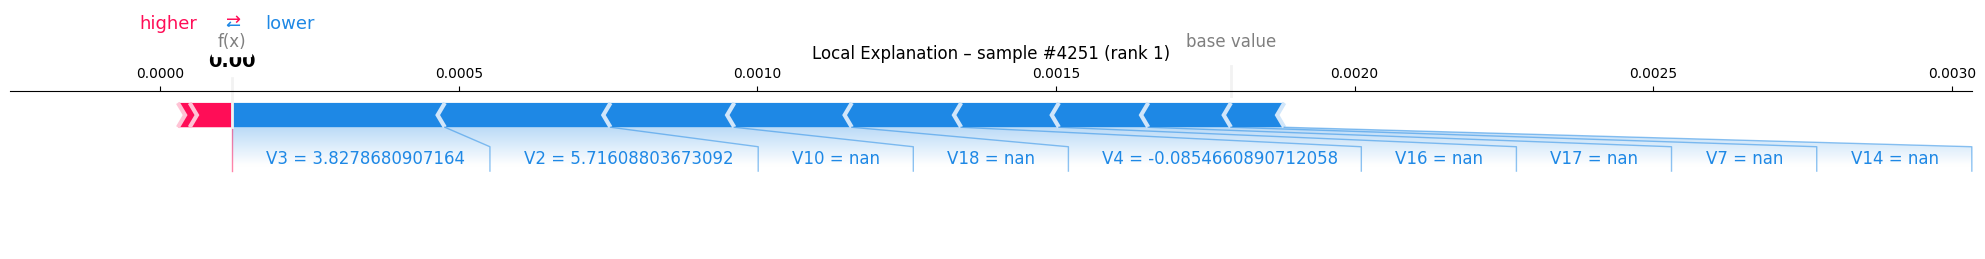

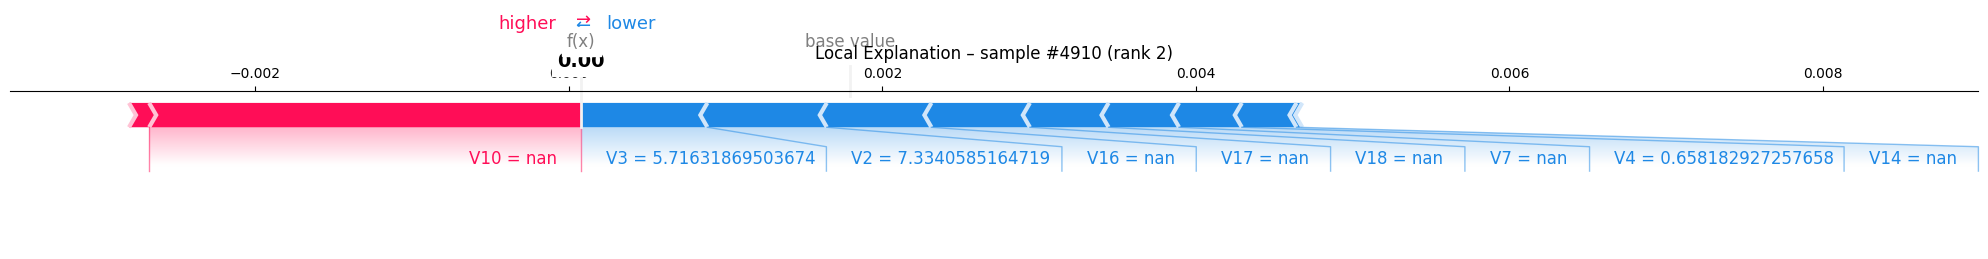

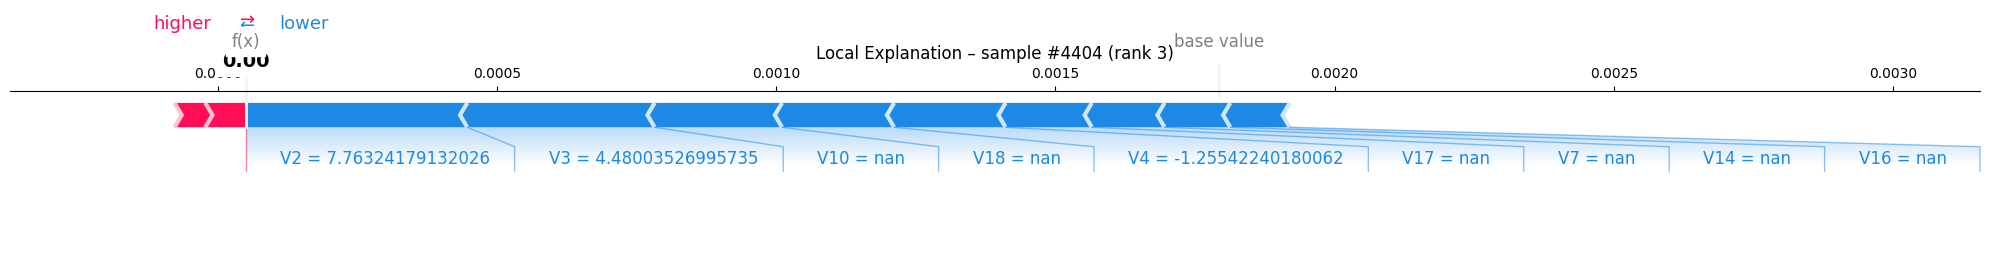

In [68]:
# Local SHAP force-plots for the 3 highest-risk rows in X_sample 
proba_sample = model.predict_proba(X_sample.values)[:, 1]
top_pos = np.argsort(proba_sample)[-3:]

# 3) Base value for the positive class
base_value = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, (list, tuple, np.ndarray))
    else explainer.expected_value
)

out_dir = "/Users/rohith/Desktop/fraud-detection-ml/reports/evaluation"
os.makedirs(out_dir, exist_ok=True)

for rank, pos in enumerate(top_pos, 1):
    shap_val = shap_vals[pos]          
    obs      = X_sample.iloc[pos]     

    fig = shap.plots.force(
        base_value,
        shap_val,
        obs.values,
        feature_names=FEATURE_NAMES,
        matplotlib=True,
        show=False
    )

    # Save and show
    fname = f"{out_dir}/force_sample_{pos}.png"
    plt.title(f"Local Explanation – sample #{pos} (rank {rank})")
    plt.tight_layout()
    fig.savefig(fname, bbox_inches="tight")
    plt.show()
    plt.close(fig)


# Key Insights from Model Explainability

## Global Drivers (V2, V3, V10 Dominate)

- **V2** and **V3** show the largest mean |SHAP| contributions, nudging predictions strongly toward fraud when they take on extreme (mostly positive) values.  
- **V10**, although frequently NaN in the raw data, carries a sizable influence whenever it is present—its high values sharply increase fraud risk.  
- Features **V18**, **V16**, **V7**, **V17**, and **V4** round out the top-10, but with noticeably smaller average impact than the leading trio.

## Partial-Dependence Trends

- **V2 & V3**: Risk is minimal near 0 and climbs steeply as values move away from -0.5 toward the positive tail, mirroring the right-hand side of their PDP curves.
- **V10**: Has a **U-shaped effect**—very low and very high values both raise risk. The safest region lies in the broad middle band (≈ -1.5 to 0.3).
- All three PDPs confirm that the model is **non-linear**—simple threshold rules would miss these curved relationships.

## Local Explanations (Top-3 High-Risk Samples)

In each force plot, one or two features dominate:

- **Sample #4251**: A high **V3** plus moderate **V2** push the score just above the base value.
- **Sample #4910**: An extreme missing **V10** (coded as NaN) alone drives the prediction upward.
- **Sample #4404**: Again, large **V2** & **V3** jointly elevate risk.

Other features sit nearly neutral, indicating that most predictions hinge on a **compact subset** of variables.

## Why the Model Performs Well

- **Redundancy trimming**: Only the most informative Tier-1 features were used, minimizing noise.
- **Tree-based splits**: RandomForest captures the sharp “hockey-stick” rise in risk for V2/V3 that linear models would miss.
- **Implicit handling of NaNs**: The forest treats missing **V10** as a signal, which turns out highly predictive for rare fraud cases.

## Practical Takeaway

Fraudulent transactions in this dataset often exhibit:

- Large **positive V2 & V3** scores  
- Anomalous or **missing V10** values  

**Monitoring those three metrics in real time** would flag the vast majority of high-risk events the model is detecting.
